In [148]:
import pandas as pd
import pyLDAvis.gensim

from matplotlib.pyplot import *
import matplotlib
import matplotlib.pyplot as plt

#from scipy.interpolate import spline
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
import gensim.models.ldamodel
import gensim
from gensim.utils import lemmatize
from nltk.corpus import stopwords
import re
from gensim.corpora import Dictionary

from pprint import pprint

import pyLDAvis.gensim
import gensim
from gensim import corpora
from gensim.models import LdaModel

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [149]:
def lemmatize(text):
    return (WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return result



# Generate different lda models to evaluate their coherence scores

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=6):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [130]:
df = pd.read_excel('../patient_data1.xlsx')

df = df.rename(columns={"Pain Increase, Decrease, No Change": 'change', 'Relevant to Pain':'relevance', 'Raw Text': 'text'})

In [131]:
df.head()

,relevance,change,text
0,yes,increase,Patient. Arrived to VDH for pain management an...
1,yes,not sure,Patient will continue on pain control regimen ...
2,yes,not sure,Patient will continue to take pain medications...
3,no,NaN,Patient received from CHC via wheelchair on ro...
4,yes,increase,Patient remains in 8-10/10 pain. PCA initiated.


In [115]:
doc_complete = df['text'].values.tolist()
doc_clean = [preprocess(str(doc)) for doc in doc_complete]

In [119]:
#pprint(doc_clean[:1])

In [118]:
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(doc) for doc in doc_clean]

In [121]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=doc_clean, start=2, limit=30, step=6)

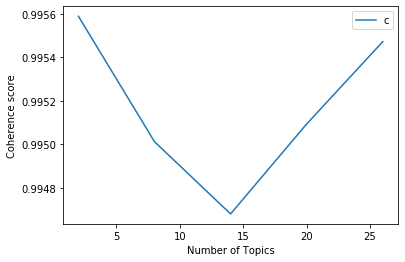

In [122]:
# Show graph
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [123]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

belong = optimal_model.print_topics(num_words=10)

[(0,
  '0.116*"pain" + 0.100*"goal" + 0.081*"progress" + 0.075*"outcome" + '
  '0.067*"ability" + 0.051*"improve" + 0.036*"problem" + 0.030*"patient" + '
  '0.027*"level" + 0.026*"manage"'),
 (1,
  '0.108*"pain" + 0.085*"outcome" + 0.071*"patient" + 0.065*"progress" + '
  '0.057*"goal" + 0.044*"ability" + 0.041*"improve" + 0.028*"decrease" + '
  '0.026*"problem" + 0.019*"level"')]


In [110]:
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
data

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.031076  0.0       1        1  74.198761
1     -0.031076  0.0       2        1  25.801241, topic_info=    Category         Freq          Term        Total  loglift  logprob
22   Default  1109.000000          pain  1109.000000  30.0000  30.0000
103  Default   210.000000         alter   210.000000  29.0000  29.0000
119  Default   322.000000       problem   322.000000  28.0000  28.0000
23   Default   432.000000       patient   432.000000  27.0000  27.0000
114  Default   241.000000         level   241.000000  26.0000  26.0000
..       ...          ...           ...          ...      ...      ...
36    Topic2    22.801641       regimen   181.924515  -0.7220  -4.7147
121   Topic2    19.259874  satisfaction   123.323807  -0.5020  -4.8835
73    Topic2    15.437783      increase    64.740509  -0.0788  -5.1047
113   Topic2    14.520222     knowledge   112.828400  -0.6956  -5.1660
71    Topic2    10.871707         shift    29.728607   0.3488  -5.4553

[144 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
102       1  0.818941    ability
102       2  0.180099    ability
281       1  0.772888        add
281       2  0.257629        add
3         1  0.378897  admission
...     ...       ...        ...
196       2  0.045977    support
64        1  0.353408       time
64        2  0.636134       time
65        1  0.353638    toradol
65        2  0.636548    toradol

[184 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# pain relevant topic distribution using the optimal model

In [135]:
pain_relevant_document = df[df['relevance'] == 'yes']['text']
relevant = list()
for i in pain_relevant_document.values.tolist():
    relevant.append(str(i))

relevant = ' '.join(relevant)

bow_vector = dictionary.doc2bow(preprocess(relevant))

for index, score in sorted(optimal_model[bow_vector], key=lambda tup: -1*tup[1]):
    pprint("Score: {}\t Topic: {}".format(score, optimal_model.print_topic(index, 10)))

('Score: 0.7665781378746033\t Topic: 0.116*"pain" + 0.100*"goal" + '
 '0.081*"progress" + 0.075*"outcome" + 0.067*"ability" + 0.051*"improve" + '
 '0.036*"problem" + 0.030*"patient" + 0.027*"level" + 0.026*"manage"')
('Score: 0.23342186212539673\t Topic: 0.108*"pain" + 0.085*"outcome" + '
 '0.071*"patient" + 0.065*"progress" + 0.057*"goal" + 0.044*"ability" + '
 '0.041*"improve" + 0.028*"decrease" + 0.026*"problem" + 0.019*"level"')


# pain irrelevant topic distribution using the optimal model

In [137]:
pain_irrelevant_document = df[df['relevance'] == 'no']['text']
irrelevant = list()
for i in pain_irrelevant_document.values.tolist():
    irrelevant.append(str(i))

irrelevant = ' '.join(irrelevant)

bow_vector = dictionary.doc2bow(preprocess(irrelevant))

for index, score in sorted(optimal_model[bow_vector], key=lambda tup: -1*tup[1]):
    pprint("Score: {}\t Topic: {}".format(score, optimal_model.print_topic(index, 10)))

('Score: 0.9913361072540283\t Topic: 0.108*"pain" + 0.085*"outcome" + '
 '0.071*"patient" + 0.065*"progress" + 0.057*"goal" + 0.044*"ability" + '
 '0.041*"improve" + 0.028*"decrease" + 0.026*"problem" + 0.019*"level"')


# pain increase topic distribution using the optimal model

In [139]:
pain_change = df[df['change'] == 'increase']['text']
change = list()
for i in pain_change.values.tolist():
    change.append(str(i))

change = ' '.join(change)

bow_vector = dictionary.doc2bow(preprocess(change))

for index, score in sorted(optimal_model[bow_vector], key=lambda tup: -1*tup[1]):
    pprint("Score: {}\t Topic: {}".format(score, optimal_model.print_topic(index, 10)))

('Score: 0.7674806714057922\t Topic: 0.108*"pain" + 0.085*"outcome" + '
 '0.071*"patient" + 0.065*"progress" + 0.057*"goal" + 0.044*"ability" + '
 '0.041*"improve" + 0.028*"decrease" + 0.026*"problem" + 0.019*"level"')
('Score: 0.23251929879188538\t Topic: 0.116*"pain" + 0.100*"goal" + '
 '0.081*"progress" + 0.075*"outcome" + 0.067*"ability" + 0.051*"improve" + '
 '0.036*"problem" + 0.030*"patient" + 0.027*"level" + 0.026*"manage"')


# pain decrease topic distribution using the optimal model

In [140]:
pain_change = df[df['change'] == 'decrease']['text']
change = list()
for i in pain_change.values.tolist():
    change.append(str(i))

change = ' '.join(change)

bow_vector = dictionary.doc2bow(preprocess(change))

for index, score in sorted(optimal_model[bow_vector], key=lambda tup: -1*tup[1]):
    pprint("Score: {}\t Topic: {}".format(score, optimal_model.print_topic(index, 10)))

('Score: 0.9603386521339417\t Topic: 0.116*"pain" + 0.100*"goal" + '
 '0.081*"progress" + 0.075*"outcome" + 0.067*"ability" + 0.051*"improve" + '
 '0.036*"problem" + 0.030*"patient" + 0.027*"level" + 0.026*"manage"')
('Score: 0.039661359041929245\t Topic: 0.108*"pain" + 0.085*"outcome" + '
 '0.071*"patient" + 0.065*"progress" + 0.057*"goal" + 0.044*"ability" + '
 '0.041*"improve" + 0.028*"decrease" + 0.026*"problem" + 0.019*"level"')


# pain uncertain topic distribution using the optimal model

In [142]:
pain_change = df[df['change'] == 'not sure']['text']
change = list()
for i in pain_change.values.tolist():
    change.append(str(i))

change = ' '.join(change)

bow_vector = dictionary.doc2bow(preprocess(change))

for index, score in sorted(optimal_model[bow_vector], key=lambda tup: -1*tup[1]):
    pprint("Score: {}\t Topic: {}".format(score, optimal_model.print_topic(index, 10)))

('Score: 0.9062216877937317\t Topic: 0.116*"pain" + 0.100*"goal" + '
 '0.081*"progress" + 0.075*"outcome" + 0.067*"ability" + 0.051*"improve" + '
 '0.036*"problem" + 0.030*"patient" + 0.027*"level" + 0.026*"manage"')
('Score: 0.09377828985452652\t Topic: 0.108*"pain" + 0.085*"outcome" + '
 '0.071*"patient" + 0.065*"progress" + 0.057*"goal" + 0.044*"ability" + '
 '0.041*"improve" + 0.028*"decrease" + 0.026*"problem" + 0.019*"level"')


# pain unchanged topic distribution using the optimal model

In [147]:
pain_change = df[df['change'] != 'no change']['text']
change = list()
for i in pain_change.values.tolist():
    change.append(str(i))

change = ' '.join(change)

bow_vector = dictionary.doc2bow(preprocess(change))

for index, score in sorted(optimal_model[bow_vector], key=lambda tup: -1*tup[1]):
    pprint("Score: {}\t Topic: {}".format(score, optimal_model.print_topic(index, 10)))

('Score: 0.7519437074661255\t Topic: 0.116*"pain" + 0.100*"goal" + '
 '0.081*"progress" + 0.075*"outcome" + 0.067*"ability" + 0.051*"improve" + '
 '0.036*"problem" + 0.030*"patient" + 0.027*"level" + 0.026*"manage"')
('Score: 0.24805638194084167\t Topic: 0.108*"pain" + 0.085*"outcome" + '
 '0.071*"patient" + 0.065*"progress" + 0.057*"goal" + 0.044*"ability" + '
 '0.041*"improve" + 0.028*"decrease" + 0.026*"problem" + 0.019*"level"')
